In [1]:
%cd ..

import torch
from einops import rearrange, repeat
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from tqdm.auto import tqdm

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
k = 8
eps = 1e-10
max_step = 300
do_kmeans = False
init_kmeans_plus2 = True

X, _ = make_blobs(n_samples=10000, centers=k, cluster_std=0.60, random_state=0)
X = torch.from_numpy(X.copy())
X_expand = repeat(X, "batch dim -> batch 1 dim")

In [3]:
torch.manual_seed(0)

cat = torch.distributions.Categorical(logits=torch.zeros(X.size(0)))
if init_kmeans_plus2:
    ids = [cat.sample()]
    C = X[ids]

    for i in range(k - 1):
        logits = (X_expand - C).norm(p=2, dim=-1).min(-1).values
        cat = torch.distributions.Categorical(logits=logits)
        ids.append(cat.sample())
        C = X[ids, :]
else:
    C = X[cat.sample([k])]

if do_kmeans:
    loss_best = torch.inf
    losses = []

    with tqdm(total=max_step, unit="step") as pbar:
        for i in range(max_step):
            distance = (X_expand - C).norm(p=2, dim=-1)

            probs = distance.neg().softmax(-1)
            probs_expand = repeat(probs, "n k -> n k 1")
            N_k = probs_expand.sum(0)

            C = (X_expand * probs_expand).sum(0) / N_k

            losses.append(-probs.log().max(-1).values.sum())

            if abs(loss_best - losses[-1]) > eps:
                loss_best = losses[-1]
            else:
                break

            pbar.set_postfix(
                [
                    ("loss", "{:.4f}".format(losses[-1])),
                    ("loss_best", "{:.4f}".format(loss_best)),
                ]
            )
            pbar.update()

    plt.plot(losses)
    plt.ylabel("$\sum^N_{i}\max_{c_k}\,\log\mathrm{softmax}(-||x_i - c_k||_2)$")
    plt.xlabel("Step")
    plt.tight_layout()

In [4]:
if do_kmeans:
    prior = torch.nn.Parameter(probs.mean(0), requires_grad=False)
else:
    prior = torch.nn.Parameter(torch.zeros(k).softmax(0), requires_grad=False)
mean = torch.nn.Parameter(C, requires_grad=False)
std = torch.nn.Parameter(torch.ones_like(C), requires_grad=False)

# Initialize distribution
mixture_distribution = torch.distributions.Categorical(prior)
component_distribution = torch.distributions.Normal(mean, std)
component_distribution = torch.distributions.Independent(component_distribution, 1)
dist = torch.distributions.MixtureSameFamily(
    mixture_distribution, component_distribution
)

loss_best = torch.inf

losses = []

with tqdm(total=max_step, unit="step") as pbar:
    # Expectation-Maximization
    for i in range(max_step):
        # Calculate posterior (E-Step)
        posterior = (
            dist.mixture_distribution.probs
            * dist.component_distribution.log_prob(X_expand).exp()
        )
        posterior = posterior / posterior.sum(-1, keepdims=True)
        prior.data = posterior.mean(0)

        # Update parameter (M-Step)
        posterior = repeat(posterior, "n k -> n k 1")
        N_k = posterior.sum(0)

        prior.data = rearrange(N_k / X.size(0), "k 1 -> (k 1)")
        mean.data = (X_expand * posterior).sum(0) / N_k
        std.data = ((posterior * (X_expand - mean).square()).sum(0) / (N_k - 1)).sqrt()

        # Check convergence status
        loss = dist.log_prob(X).mean().neg()

        if torch.isnan(loss):
            raise ValueError("Found NaN loss!")

        if 0.0 - eps < prior.sum() > 1.0 + eps:
            raise ValueError("Invalid prior!")

        losses.append(loss.item())

        if abs(loss_best - losses[-1]) > eps:
            loss_best = losses[-1]
        else:
            break

        # Update progress
        pbar.set_postfix(
            [
                ("loss", "{:.4f}".format(losses[-1])),
                ("loss_best", "{:.4f}".format(loss_best)),
            ]
        )
        pbar.update()

  0%|          | 0/300 [00:00<?, ?step/s]

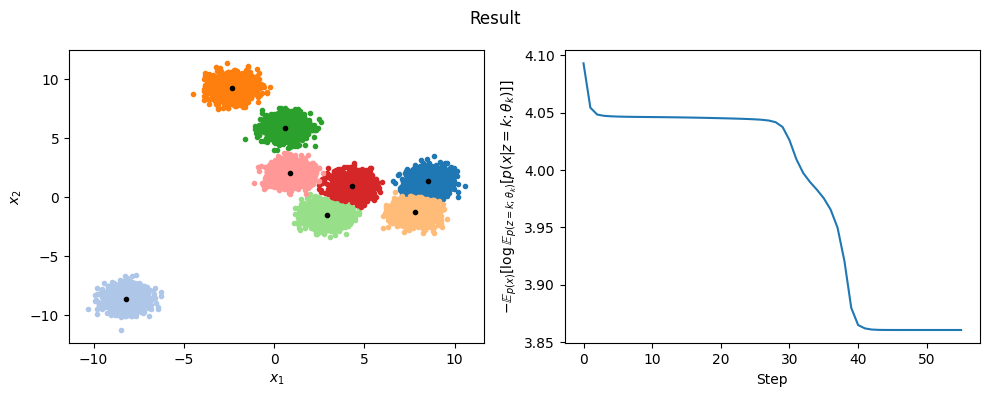

In [5]:
color = plt.cm.tab20.colors

fig = plt.figure(figsize=(10, 4))

fig.suptitle("Result")

ax1 = fig.add_subplot(1, 2, 1)
for i in range(k):
    X_c = X[posterior.argmax(1).squeeze(-1) == i]
    ax1.plot(X_c[:, -1], X_c[:, 0], ".", color=color[i % len(color)])
ax1.plot(mean[:, -1], mean[:, 0], ".", color="k", label="Mixture")
if do_kmeans:
    plt.plot(C[:, -1], C[:, 0], ".", color="blue", label="k-Means")
    plt.legend(title="Model")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(losses)
ax2.set_ylabel(
    "$-\mathbb{E}_{p(x)}[\log\mathbb{E}_{p(z=k;\\theta_k)}[p(x|z=k;\\theta_k)]]$"
)
ax2.set_xlabel("Step")

fig.tight_layout()

In [6]:
from copy import deepcopy
from math import log

import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

from mixture.gaussian import GaussianMixture

k = 8
X, _ = make_blobs(n_samples=10000, centers=k, cluster_std=0.60, random_state=0)
X = torch.from_numpy(X.copy())

In [7]:
result = []
models = []

torch.manual_seed(0)

restarts = 10
k_max = 10
for k_i in range(1, k_max + 1):
    bic_best = float("inf")
    for _ in range(restarts):
        gmm = GaussianMixture(k_i)
        gmm.fit(X)
        if bic_best > (
            bic_current := sum(p.numel() for p in gmm.parameters()) * log(X.size(0))
            + 2 * gmm.loss[-1] * X.size(0)
        ):
            bic_best = bic_current
            model_best = deepcopy(gmm)

    result.append(bic_best)
    models.append(model_best)

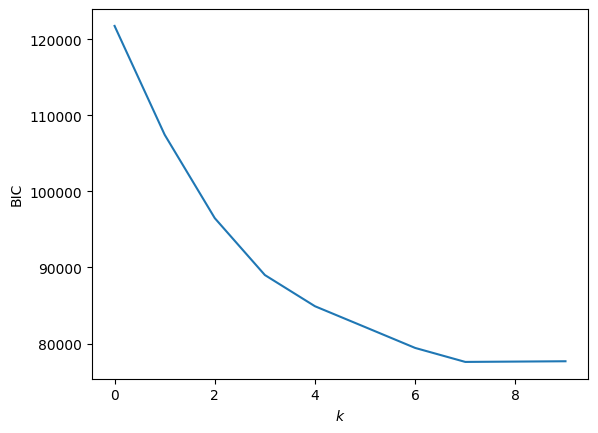

In [8]:
plt.xlabel("$k$")
plt.ylabel("BIC")
plt.plot(result)

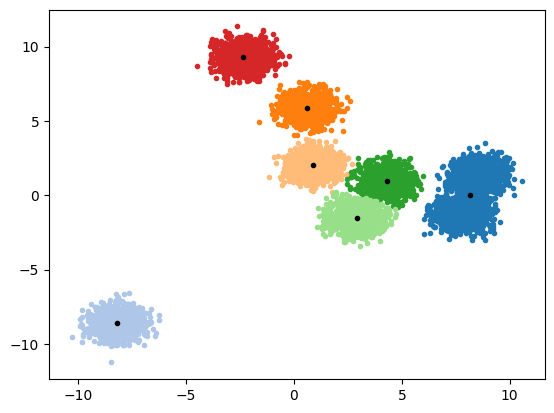

In [9]:
color = plt.cm.tab20.colors

k_ = 6

posterior = models[k_].expectation(X).argmax(-1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(k_ + 1):
    X_i = X[posterior == i]
    ax.plot(X_i[:, -1], X_i[:, 0], ".", color=color[i % len(color)])
ax.plot(
    models[k_].params["mean"][:, -1],
    models[k_].params["mean"][:, 0],
    ".",
    color="k",
    label="Mixture",
)

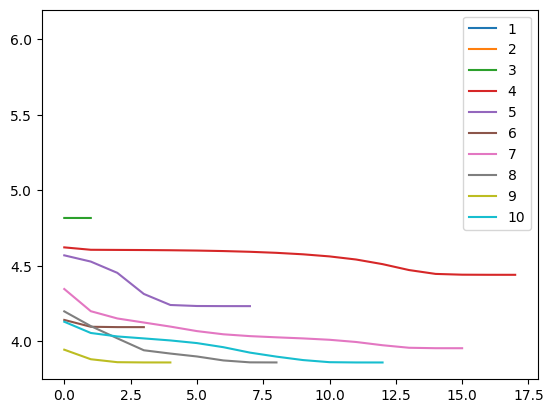

In [10]:
for i in range(len(models)):
    plt.plot(models[i].loss, label=i + 1)
plt.legend()

In [11]:
from einops import repeat

posterior = repeat(models[5].expectation(X), "... k -> ... k 1")
stats = models[5].calculate_weigthed_stats(X, posterior)

In [1]:
%cd ..

from copy import deepcopy
from math import log

import pandas as pd
import torch

from mixture.poisson import PoissonMixture

df_train = pd.read_csv("dataset/coco2017-cooccurences-train.csv")

inp = torch.from_numpy(df_train.iloc[:, 8:].to_numpy()).float()

# inp = torch.poisson(torch.zeros(1000, 2).uniform_(0.1, 1))

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
inp = torch.from_numpy(
    df_train.iloc[:, 8:].sample(15000, replace=False).to_numpy()
).float()

In [4]:
result = []
models = []

torch.manual_seed(0)

restarts = 10
k_max = 20
for k_i in range(1, k_max + 1):
    bic_best = float("inf")
    for _ in range(restarts):
        pm = PoissonMixture(k_i)
        pm.fit(inp)
        if bic_best > (
            bic_current := pm.loss[-1] * inp.size(0)
            + sum(p.numel() for p in pm.parameters()) / (2 * log(inp.size(0)))
        ):
            bic_best = bic_current
            model_best = deepcopy(pm)
    result.append(bic_best)
    models.append(model_best)

    print(k_i, "{:,.4f}".format(result[-1]))

1 362,852.0312
2 326,743.7188
3 299,512.5938
4 290,213.2188
5 281,506.0938
6 274,353.5938
7 267,984.7188
8 264,237.0625
9 259,088.4219
10 257,065.1875
11 253,870.3906
12 251,176.4688
13 247,942.1875
14 246,165.1719
15 243,223.2812
16 241,739.9219
17 240,572.0469
18 237,390.7344
19 236,423.2031
20 234,789.5781


In [ ]:
gmm.dist.component_distribution.base_dist.gate

In [17]:
models[7].prior

tensor([0.4999, 0.0870, 0.0850, 0.1232, 0.0436, 0.0947, 0.0199, 0.0467])

In [ ]:
(inp <= 0).sum(0)

In [ ]:
plt.xlabel("$k$")
plt.ylabel("BIC")
plt.plot(result)

In [ ]:
for i, model in enumerate(models, 1):
    plt.plot(model.loss, label=i)
plt.legend()

In [ ]:
%cd ..

In [ ]:
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange, repeat
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from torch.distributions import (
    Categorical,
    Independent,
    MixtureSameFamily,
    Normal,
    Poisson,
)
from tqdm.auto import tqdm

from utils.dataset import ObjectCooccurrenceCOCODataset
from utils.distribution import HurdleDistribution

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(0)

dataset = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")

batch_size = 1024
batch_size = len(dataset) // 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size, True)
sampler = Categorical(logits=torch.zeros(dataset.features.shape[0]))

max_step = 100
num_restarts = 10
max_ks = 20
tolerance_max = 20

lr_base = 1.0
lr = lr_base * dataloader.batch_size / 128

models = []
losses_k = []
for k in (pbar1 := tqdm(range(1, max_ks + 1))):
    losses = []
    loss_best = float("inf")
    for trial in (pbar := tqdm(range(1, num_restarts + 1), leave=False)):
        pbar.set_description("Fitting k = {:0=2d}".format(k))

        params = torch.nn.ParameterDict()
        params["mixture_logits"] = torch.nn.Parameter(torch.zeros(k))
        params["rate"] = torch.nn.Parameter(
            torch.from_numpy(
                dataset.features.iloc[sampler.sample([k])].to_numpy()
            ).float()
        )
        params["gate_logits"] = torch.nn.Parameter(torch.zeros_like(params["rate"]))

        params = params.to(device)

        opt = torch.optim.Adam(params.parameters(), lr)
        sch = torch.optim.lr_scheduler.OneCycleLR(
            opt, lr, epochs=max_step, steps_per_epoch=len(dataloader)
        )

        loss_step_old = float("inf")
        tolerance = 0
        for i in range(max_step):
            for inputs in dataloader:
                inputs = inputs.to(device)

                logits = params["mixture_logits"]
                rate = F.softplus(params["rate"])
                gate = params["gate_logits"].sigmoid()

                mix_dist = Categorical(logits=logits)
                comp_dist = Poisson(rate + 1e-5)
                comp_dist = HurdleDistribution(comp_dist, gate=gate)
                comp_dist = Independent(comp_dist, 1)
                dist = MixtureSameFamily(mix_dist, comp_dist)

                ll = mix_dist.logits + comp_dist.log_prob(inputs[:, None, :])
                obj = ll.detach().softmax(-1) * ll
                obj = obj.sum(-1).mean().neg()

                obj.backward()
                opt.step()
                sch.step()
                opt.zero_grad()

        loss = 0
        n = 0
        for inputs in dataloader:
            inputs = inputs.to(device)
            with torch.no_grad():
                loss += dist.log_prob(inputs).sum().neg().item()
                n += inputs.size(0)

        losses.append(loss / n)

        if loss_best > losses[-1]:
            loss_best = losses[-1]
            params_best = deepcopy(params.cpu())
        else:
            tolerance += 1

        if tolerance > tolerance_max:
            break

        pbar.set_postfix(
            OrderedDict(
                [("current", f"{losses[-1]:.4f}"), ("best", f"{loss_best:.4f}")]
            )
        )

    torch.save(params_best.state_dict(), f"outputs/mixture_{k:0=2d}.pt")

In [ ]:
logits = params_best["mixture_logits"]
rate = F.softplus(params_best["rate"])
gate = params_best["gate_logits"].sigmoid()

mix_dist = Categorical(logits=logits)
comp_dist = Poisson(rate + 1e-5)
comp_dist = HurdleDistribution(comp_dist, gate=gate)
comp_dist = Independent(comp_dist, 1)
dist = MixtureSameFamily(mix_dist, comp_dist)

loss = 0
n = 0
for inputs in dataloader:
    with torch.no_grad():
        loss += dist.log_prob(inputs).sum().neg().item()
        n += inputs.size(0)

dataset = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")
inputs = torch.from_numpy(dataset.features.to_numpy()).to(device)
ll = mix_dist.logits + comp_dist.log_prob(inputs[:, None, :])
posterior = ll.softmax(-1)

In [ ]:
from IPython.display import Image

assign = posterior.max(-1).indices
for i in range(10):
    try:
        sample = dataset.metadata.iloc[np.where(assign == i)].sample(5, replace=False)
        print("Group", i + 1)
        for row in sample.iloc:
            display(Image(row.coco_url, height=100, width=100))
    except:
        pass